## Autofocus multi-label prediction

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Prepare the CSV

In [3]:
import pandas as pd

In [5]:
DATA_DIR = Path() / '..' / '..' / 'data' / 'lpz_2016_2017' / 'processed'
CSV_PATH_IN = DATA_DIR / 'labels.csv'

In [11]:
autofocus_df = pd.read_csv(CSV_PATH_IN)

In [12]:
autofocus_df.head()

,filename,label,grayscale,mean_brightness,date,location
0,CHIL - D02-BMT1-JU16_00128.JPG,human,0.0,52.990674,12-Jul-16,BMT1
1,CHIL - D02-BMT1-JU16_00129.JPG,human,0.0,121.413798,12-Jul-16,BMT1
2,CHIL - D02-BMT1-JU16_00130.JPG,empty,0.0,90.377277,12-Jul-16,BMT1
3,CHIL - D02-BMT1-JU16_00131.JPG,human,0.0,107.500902,12-Jul-16,BMT1
4,CHIL - D02-BMT1-JU16_00132.JPG,human,1.0,197.944264,12-Jul-16,BMT1


In [14]:
autofocus_df.loc[:, "location"] = autofocus_df.loc[:, "filename"].apply(
    lambda fn: fn.split("-")[2]
)

In [15]:
autofocus_df = autofocus_df.loc[autofocus_df.loc[:, 'label'].notna(), ['filename', 'label', 'location']]

In [16]:
autofocus_df.head()

,filename,label,location
0,CHIL - D02-BMT1-JU16_00128.JPG,human,BMT1
1,CHIL - D02-BMT1-JU16_00129.JPG,human,BMT1
2,CHIL - D02-BMT1-JU16_00130.JPG,empty,BMT1
3,CHIL - D02-BMT1-JU16_00131.JPG,human,BMT1
4,CHIL - D02-BMT1-JU16_00132.JPG,human,BMT1


In [17]:
labelmap = {item:item for item in autofocus_df.loc[:, 'label'].unique()}

In [18]:
labelmap['fox squirrel'] = 'squirrel'
labelmap['e. cottontail'] = 'rabbit'
labelmap["squirrel (can'\nsquirrel (can't ID)"] = 'squirrel'
labelmap["gray fox"] = 'fox'
labelmap["w. t. deer"] = 'deer'
labelmap['melanistic grey squirrel'] = 'squirrel'
labelmap['flying squirrel'] = 'squirrel'
labelmap['gray squirrel'] = 'squirrel'
labelmap['v. opossum'] = 'opossum'
labelmap['striped skunk'] = 'skunk'
labelmap['lawn mower'] = 'human'
labelmap['Mower'] = 'human'
labelmap['red fox'] = 'fox'

In [19]:
autofocus_df.loc[:, 'label'] = autofocus_df.loc[:, 'label'].map(labelmap)

In [20]:
autofocus_df.loc[:, 'label'].unique()

array(['human', 'empty', 'dog', 'unknown', 'squirrel', 'bird', 'rabbit', 'raccoon', 'cat', 'chipmunk', 'coyote',
       'mouse', 'fox', 'deer', 'woodchuck', 'rat', 'opossum', 'skunk', 'beaver', 'mink', 'muskrat'], dtype=object)

In [21]:
autofocus_df = autofocus_df.groupby('filename').agg({'label': lambda x: ';'.join(x), 'location': min})

In [22]:
autofocus_df = autofocus_df.reset_index()

In [23]:
valid_locations = random.sample(autofocus_df.loc[:, 'location'].unique().tolist(), 10)

In [24]:
autofocus_df.loc[:, 'valid'] = autofocus_df.loc[:, 'location'].isin(valid_locations)

In [28]:
autofocus_df.to_csv('../../data/lpz_2016_2017/processed/multilabel.csv', index=False)

## Create the DataBunch

In [32]:
src = (ImageList.from_csv(DATA_DIR, 'multilabel.csv', folder='images', suffix='')
       .split_by_rand_pct(0.1)
       .label_from_df(label_delim=';')
      )

In [33]:
tfms = get_transforms()

In [34]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

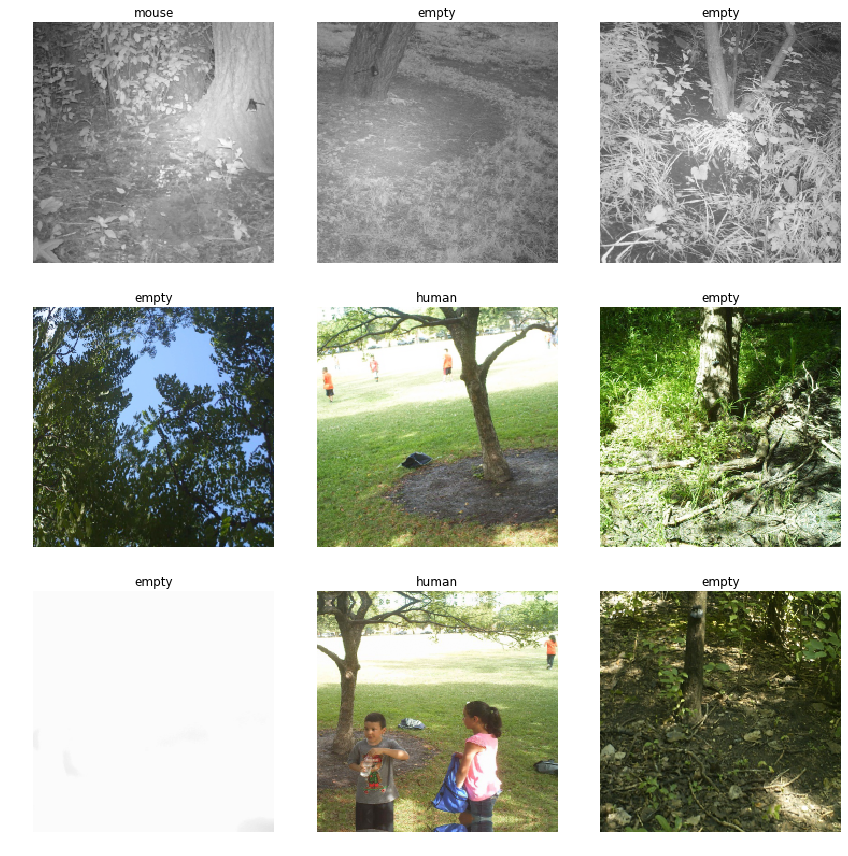

In [35]:
data.show_batch(rows=3)

## Multiclassification

In [32]:
arch = models.resnet50

In [33]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [54]:
# learn.lr_find()

In [55]:
# learn.recorder.plot()

Then we can fit the head of our network.

In [56]:
lr = 3e-2

In [57]:
# learn.fit_one_cycle(2, slice(lr))

In [58]:
# learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [59]:
# learn.unfreeze()

In [60]:
# learn.load('stage-2-rn34')

Learner(data=ImageDataBunch;

Train: LabelList (70873 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
human,empty,human,human,empty
Path: /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed;

Valid: LabelList (7874 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
rabbit,empty,empty,empty,empty
Path: /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), strid

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(1, slice(1e-5, lr/5))

In [ ]:
# learn.save('stage-2-rn50')

In [ ]:
# learn.get_preds()

In [ ]:
# preds = _

In [ ]:
# human_probs = preds[0][:, 8]

In [ ]:
# human_pred = human_probs > .5

In [ ]:
# is_human = np.array([int(item[0] == 8) for item in learn.data.valid_ds.y.items])

In [ ]:
# from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve

In [ ]:
# accuracy_score(human_pred, is_human)

In [ ]:
# mat = confusion_matrix(is_human, human_pred)

In [ ]:
# mat

In [ ]:
# fpr, tpr, thresholds = roc_curve(is_human, human_probs, pos_label=1)

In [ ]:
# tpr

In [ ]:
# fig, ax = plt.subplots()
# plt.plot(fpr, tpr, color='darkorange')

In [ ]:
# from sklearn.metrics import fbeta_score

In [ ]:
# import numpy as np

# for thresh in np.linspace(0.1, .99, 99):
#     human_pred = human_probs > thresh
#     tp = sum(is_human & np.array(human_pred))
#     fp = sum(~is_human & np.array(human_pred))
#     fn = sum(is_human & ~np.array(human_pred))
#     precision = tp/(tp + fp)
#     recall = tp/(tp + fn)
#     fbeta = fbeta_score(y_true=is_human, y_pred=human_pred, beta=.1)
#     print(thresh, precision, recall, fbeta)

In [35]:
!ls /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed/models

stage-1-512-rn50.pth  stage-2-256-rn50.pth  tmp.pth
stage-1-rn34.pth      stage-2-rn34.pth


In [36]:
data = (src.transform(tfms, size=512)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (70873 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
human,human,empty,human,human
Path: /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed;

Valid: LabelList (7874 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
empty,empty,human,raccoon;raccoon,empty
Path: /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 

In [39]:
preds = learn.get_preds()

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve

accuracy at 0.5%: 0.9996185011977867
precision at 0.5%: 0.8843387934478626
recall at 0.5%: 0.9594711746857391


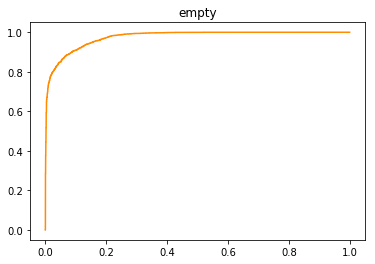

accuracy at 0.5%: 0.9998575604994347
precision at 0.5%: 0.9513184584178499
recall at 0.5%: 0.8679827267119062


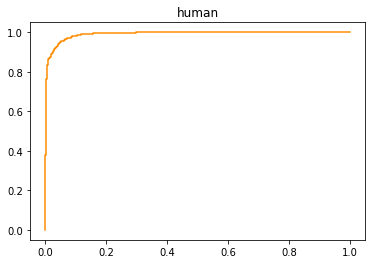

accuracy at 0.5%: 0.9999213096465409
precision at 0.5%: 0.9174311926605505
recall at 0.5%: 0.5882352941176471


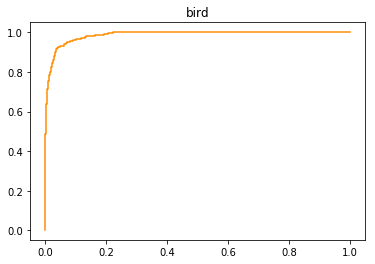

accuracy at 0.5%: 0.999925293968235
precision at 0.5%: 0.9024390243902439
recall at 0.5%: 0.6379310344827587


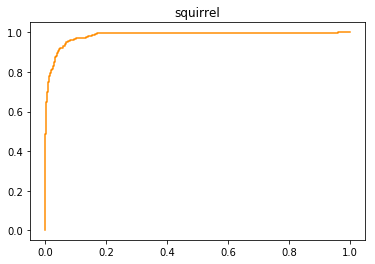

accuracy at 0.5%: 0.9999407332147998
precision at 0.5%: 0.8671586715867159
recall at 0.5%: 0.7389937106918238


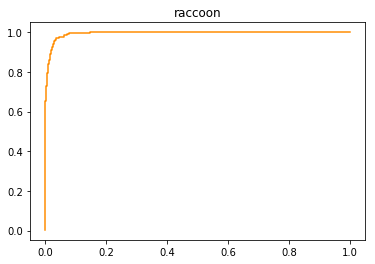

accuracy at 0.5%: 0.9999626469841175
precision at 0.5%: 0.6375
recall at 0.5%: 0.5257731958762887


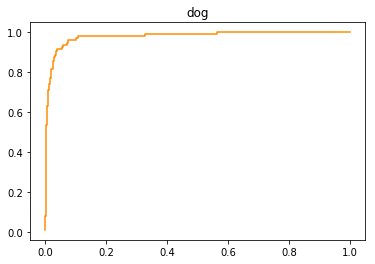

accuracy at 0.5%: 0.9999780862306823
precision at 0.5%: 0.8636363636363636
recall at 0.5%: 0.7661290322580645


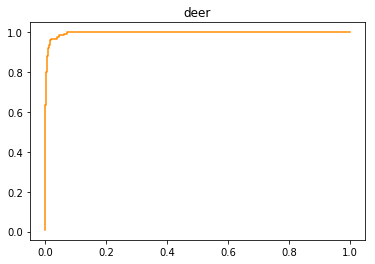

accuracy at 0.5%: 0.9999745999491999
precision at 0.5%: 0.9558823529411765
recall at 0.5%: 0.5752212389380531


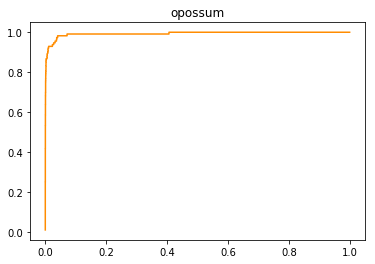

accuracy at 0.5%: 0.9999711136677175
precision at 0.5%: 0.9230769230769231
recall at 0.5%: 0.3956043956043956


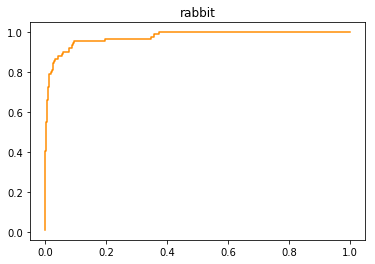

accuracy at 0.5%: 0.9999646391449646
precision at 0.5%: nan
recall at 0.5%: 0.0


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in long_scalars


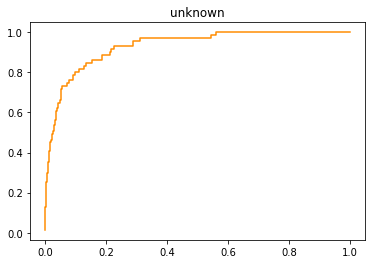

accuracy at 0.5%: 0.9999860548740706
precision at 0.5%: 0.7878787878787878
recall at 0.5%: 0.5531914893617021


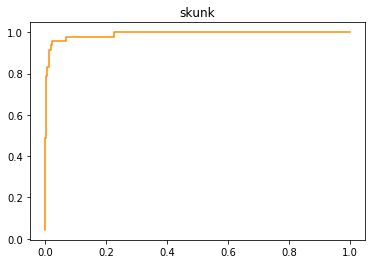

accuracy at 0.5%: 0.9999905372359764
precision at 0.5%: 1.0
recall at 0.5%: 0.5681818181818182


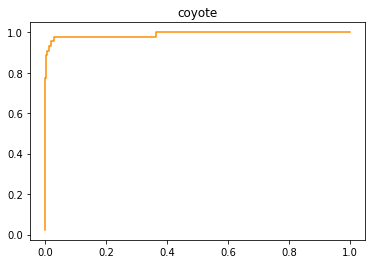

accuracy at 0.5%: 0.9999935254772471
precision at 0.5%: 1.0
recall at 0.5%: 0.2777777777777778


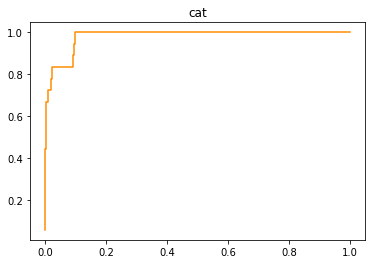

accuracy at 0.5%: 0.9999935254772471
precision at 0.5%: nan
recall at 0.5%: 0.0


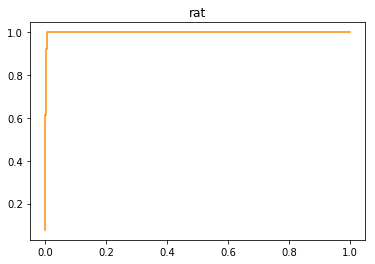

accuracy at 0.5%: 0.9999960156783059
precision at 0.5%: nan
recall at 0.5%: 0.0


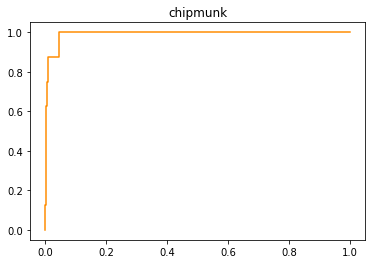

accuracy at 0.5%: 0.9999965137185176
precision at 0.5%: 0.5
recall at 0.5%: 0.14285714285714285


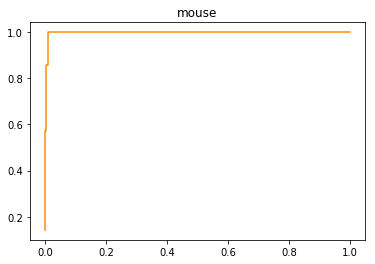

accuracy at 0.5%: 1.0
precision at 0.5%: nan
recall at 0.5%: nan


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in long_scalars
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


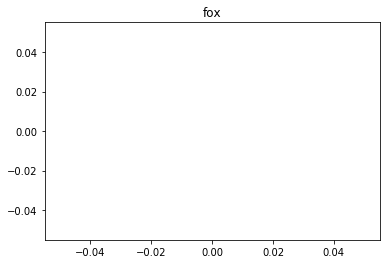

In [44]:
thresh = .5

for labelnum in pd.Series(learn.data.valid_ds.y.items.sum()).value_counts().index:
    label = data.classes[labelnum]
    label_probs = preds[0][:, labelnum]
    has_label = np.array([int(item[0] == labelnum) for item in learn.data.valid_ds.y.items])
    
    label_pred = label_probs > thresh
    tp = sum(has_label & np.array(label_pred))
    tn = sum(~has_label & ~np.array(label_pred))
    fp = sum(~has_label & np.array(label_pred))
    fn = sum(has_label & ~np.array(label_pred))
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    print(f'accuracy at {thresh}%: {accuracy}')
    print(f'precision at {thresh}%: {precision}')
    print(f'recall at {thresh}%: {recall}')

    fpr, tpr, thresholds = roc_curve(has_label, label_probs, pos_label=1)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange')
    ax.set_title(label)
    plt.show()

In [27]:
data = (src.transform(tfms, size=512)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [62]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


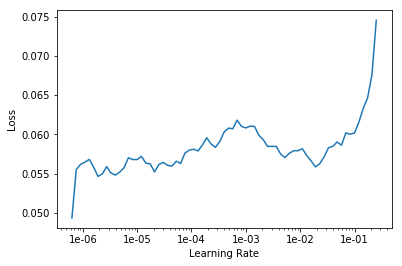

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
lr=1e-2/2

In [65]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
1,0.041960,0.058458,0.982395,0.892544,18:07


KeyboardInterrupt: 

In [66]:
learn.save('stage-1-512-rn50')

In [67]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


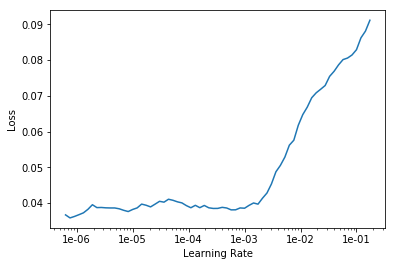

In [68]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
1,0.039169,0.036090,0.983375,0.897256,19:15
2,0.038587,0.032235,0.983702,0.901588,19:14


In [ ]:
learn.save('stage-2-256-rn50')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.export()

In [28]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (70873 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
human,human,empty,human,human
Path: /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed;

Valid: LabelList (7874 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
empty,empty,empty,empty,raccoon
Path: /home/ec2-user/image_drive/autofocus/data/lpz_2016_2017/processed;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stri

In [30]:
lr = 3e-2

In [31]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
1,0.035010,0.390485,0.981246,0.910249,18:09


KeyboardInterrupt: 

In [ ]:
learn.save('stage-3-512-rn50')

In [ ]:
learn.recorder.plot_losses()